In [25]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "#1f1e1e"}

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
local_covid_19_data = '/Users/davidmorton/Documents/COVID-19/'

!git -C $local_covid_19_data pull

states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'District of Columbia', 'Northern Mariana Islands', 'Virgin Islands']


Already up to date.


In [223]:
def get_single_date_data(date):
    datestr = date.strftime('%m-%d-%Y')
    filename = local_covid_19_data + 'csse_covid_19_data/csse_covid_19_daily_reports_us/' + datestr + '.csv'
    result = pd.read_csv(filename)
    result['Date'] = date
    return result

def get_daily_report_data():
    start_date_for_daily_data = datetime(2020, 4, 12)
    current_date = start_date_for_daily_data

    yesterday = (datetime.now() + timedelta(days = -1))
    #yesterday = datetime.now()
    lastdate = yesterday.strftime('%m-%d-%Y')
    
    series = pd.DataFrame()

    while True:
        series = series.append(get_single_date_data(current_date))
        current_date = current_date + timedelta(days = 1)
        if current_date > yesterday:
            break
    
    
    return series

def get_heatmap_data():
    states_to_drop = ['Puerto Rico', 'American Samoa', 'Guam', 'Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Recovered']

    # Get the daily report, and immediately sort it by province and date, and remove the non-state territories. 
    data = get_daily_report_data()[['Province_State', 'Date', 'Confirmed', 'People_Tested']]
    data = data.sort_values(by=['Province_State', 'Date']).reset_index()
    data = data[~data['Province_State'].isin(states_to_drop)]
    data = data.set_index(['Province_State', 'Date'])

    # Create a confirmed percentage column, and then roll it in a 7-day rolling average
    data['NewTests'] = data.sort_values(by=['Province_State', 'Date']).groupby('Province_State')['People_Tested'].diff()
    data['NewConfirmed'] = data.sort_values(by=['Province_State', 'Date']).groupby('Province_State')['Confirmed'].diff()
    data['NTRolling'] = data.reset_index().set_index('Date')[['NewTests', 'Province_State']].groupby('Province_State').rolling(window=7).mean()
    data['NCRolling'] = data.reset_index().set_index('Date')[['NewConfirmed', 'Province_State']].groupby('Province_State').rolling(window=7).mean()


    data['ConfirmedPercent'] = data['NCRolling'].div(data['NTRolling'])
    data[data['ConfirmedPercent']<0] = np.nan
    data[data['ConfirmedPercent']==np.inf] = np.nan


    data['ConfirmedPercent'] = data.groupby(['Province_State']).apply(lambda group: group['ConfirmedPercent'].interpolate()).reset_index(level=1, drop=True)
    data['ConfirmedPercentRolling'] = data.sort_values(by=['Province_State', 'Date']).groupby('Province_State')['ConfirmedPercent'].rolling(window=7).mean().reset_index(level=1, drop=1)

    # Create a pivot table for use in the heatmap.
    data = data.reset_index()[['Province_State', 'Date', 'ConfirmedPercentRolling']].pivot(values='ConfirmedPercentRolling', index='Date', columns='Province_State')
    data = data.reindex(data.idxmax().sort_values().index, axis=1).dropna()
    #data = data.reindex(data[-1:].transpose().sort_values(by=data[-1:].transpose().columns[0], ascending=False).index, axis=1).dropna()


    return data

def draw_figure():
    xxp = get_heatmap_data()
    
    ylabels = [' {0} '.format(a[0], a[1]*100) for a in zip(xxp.columns, xxp.mean().sort_values(ascending=False))]
    xlabels = [list(reversed(pd.Series(xxp.index)))[i].strftime('%B %-d') if i % 7==0 else '' for i in np.arange(len(xxp.index)-1,-1, -1)]

    plt.style.use('dark_background')
    plt.subplots(figsize=(18,23))

    ax = sns.heatmap(xxp.transpose() * 100, 
                     vmin=0, 
                     vmax=20, 
                     cmap='Blues_r')

    ax.set_xticklabels(labels=xlabels, rotation=45, ha='right', size=14)
    ax.set_xlabel('')
    ax.set_yticklabels(labels=ylabels, size=14)
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', length=0)

    ax.collections[0].colorbar.ax.tick_params(labelsize=14)

    ax.set_title('7-Day Rolling Average of Positive COVID-19\nTest Results Sorted by When The Peak Happened', size=36, pad=20, fontname='Helvetica')
    
    plt.annotate('Source: Johns Hopkins COVID-19 Data (https://github.com/CSSEGISandData/COVID-19)', (0,0), (100, -90), xycoords='axes fraction', fontname='Helvetica', textcoords='offset points', size=14, va='top')
    plt.savefig("covid19-confirmed-heatmap.png", bbox_inches="tight", pad_inches=0.5)
    


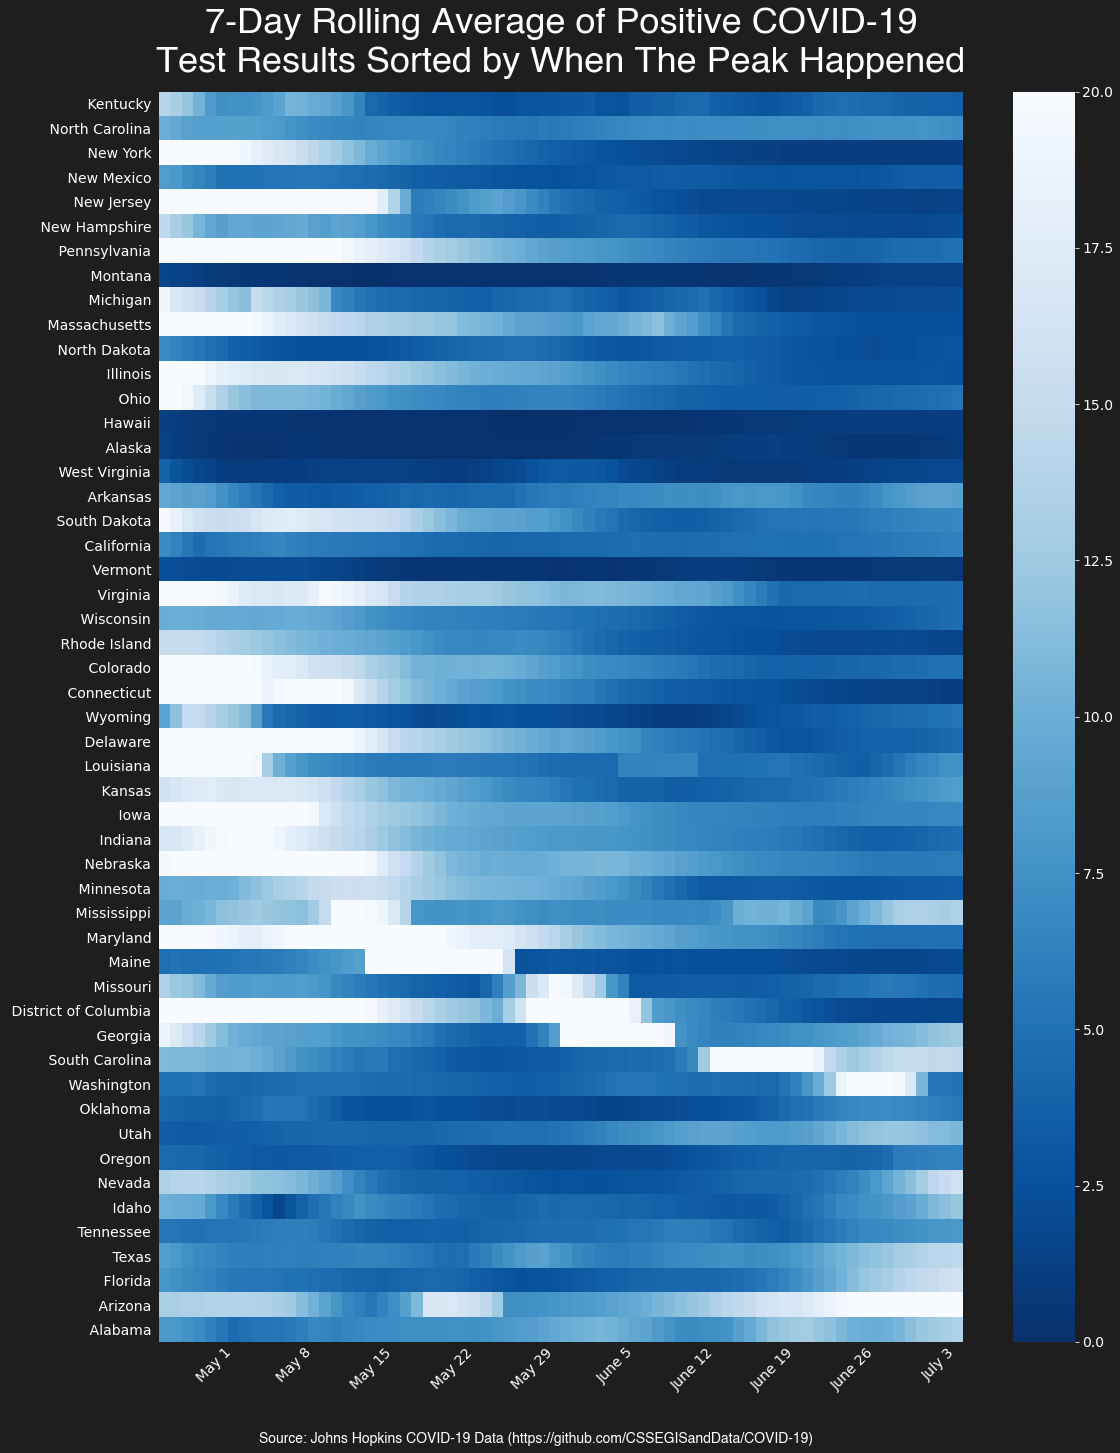

In [224]:
draw_figure()